In [107]:
#import necessary libraries
import pandas as pd
import numpy as np
import preprocessing
import running_model
import model_training
from scipy import stats

#visualisation libraries
import matplotlib.pyplot as plt
import networkx as nx
import visualisation

import itertools
import inspect
import operator
import time

import sklearn

# Data Importing and Preprocessing

In [2]:
ID,babies_connectivity_matrix=preprocessing.babies_connectivity_extraction('./Tracts/')
ROIs_combinations=preprocessing.ROIs_combinations('./Regions_of_interests.csv')
structural_labels=pd.read_csv('all_labels.csv', header = None, sep='\t')
structural_labels=np.asarray(structural_labels[1])
babies_structural_matrix=pd.read_csv('./ePrime-structure-volumes.csv',header=0,index_col=None).dropna()
babies_structural_matrix=babies_structural_matrix.iloc[babies_structural_matrix['Age at scan'].values<49,:].reset_index(drop=True)

this file dataProb_EP1085_mat.txt is not processed
this file dataProb_EP1078_mat.txt is not processed
this file cannot be loaded: .DS_Store
this file dataProb_EP1118_mat.txt is not processed
this file dataProb_EP1009_mat.txt is not processed
this file dataProb_EP1092_mat.txt is not processed
this file dataProb_EP1142_mat.txt is not processed
this file dataProb_EP1130_mat.txt is not processed
this file dataProb_EP1041_mat.txt is not processed
this file dataProb_EP1017_mat.txt is not processed
this file dataProb_EP1105_mat.txt is not processed
this file dataProb_EP1123_mat.txt is not processed


In [3]:
#Reading necessary tables
schizophrenia_high_scores_european=preprocessing.read_table_from_txt('./scz2_sixlevels_ld1000G.highres.all.score.txt')
ancestral_PCA_european=preprocessing.read_table_from_txt('./ePrime_nosibs_european_pruned_excludeLD_pca10.eigenvec.txt')

In [4]:
#matching europeans IDs between tables and connectivity matrices
european_ID_list=list(set(ID).intersection(schizophrenia_high_scores_european['ID']))#this is crossing connectivity_ID with european_PRS_ID.
european_ID_list=list(set(european_ID_list).intersection(babies_structural_matrix['Subject ID']))#this is crossing european_connectivity with babies_structural_ID.
european_ID_list.sort()
european_ID_list_not_available=np.setdiff1d(schizophrenia_high_scores_european['ID'],european_ID_list)
european_ID_list_not_available.sort()
print('these %d individuals do not have connectivity matrices or structural data: %s' %(len(european_ID_list_not_available),european_ID_list_not_available))

these 17 individuals do not have connectivity matrices or structural data: ['EP1554' 'EP1688' 'EP1910' 'EP2443' 'EP2741' 'EP3137' 'EP3941' 'EP4038'
 'EP4063' 'EP4845' 'EP5175' 'EP5942' 'EP6140' 'EP7153' 'EP7384' 'EP7427'
 'EP7687']


## remmoving outliers

(122, 11)
['EP2314' 'EP4187' 'EP4692' 'EP4795' 'EP5930' 'EP6016' 'EP6402' 'EP9557']


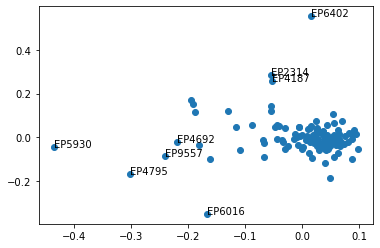

In [5]:
#outlier removal from 2 ancestral principal(?) components.

#matching available ancestrial PC ID 
european_ancestral_PCA_w_outliers=preprocessing.extract_by_ID(european_ID_list,ancestral_PCA_european['ID'],ancestral_PCA_european)
print(european_ancestral_PCA_w_outliers.shape)

from scipy import stats
zscores=np.abs(stats.zscore(european_ancestral_PCA_w_outliers[:,1:3].astype('float64'),axis=0))
outliers=np.where(zscores>=2.5)[0]#remove anything more than 3 st. deviation from the mean.
print(european_ancestral_PCA_w_outliers[outliers,0])
#removing outliers using the ancestrial PCA

fig,ax= plt.subplots()
ax.scatter(european_ancestral_PCA_w_outliers[:,1],european_ancestral_PCA_w_outliers[:,2])
for i,txt in enumerate(european_ancestral_PCA_w_outliers[outliers,0]):
    ax.annotate(txt,(european_ancestral_PCA_w_outliers[outliers,1][i],european_ancestral_PCA_w_outliers[outliers,2][i]))


In [6]:
#Updated lists to remove the outliers:

european_ID_list_without_outliers=preprocessing.extract_by_ID(european_ancestral_PCA_w_outliers[outliers,0],european_ID_list,european_ID_list,remove=True)

###########################################################

#extracting the european connectivity matrices
european_connectivity_matrices_schizophrenia=preprocessing.extract_by_ID(european_ID_list_without_outliers,ID,babies_connectivity_matrix)
#extracting the european structural matrices
european_structural_matrices_schizophrenia=preprocessing.extract_by_ID(european_ID_list_without_outliers,babies_structural_matrix['Subject ID'],babies_structural_matrix)
print(european_connectivity_matrices_schizophrenia.shape)
print(european_structural_matrices_schizophrenia.shape)
#matching available ancestrial PC ID // i am transforming all data to array list so I can work easier with scikit learn later on (is it necessary? idk)
european_ancestral_PCA=preprocessing.extract_by_ID(european_ID_list_without_outliers,ancestral_PCA_european['ID'],ancestral_PCA_european)
print(european_ancestral_PCA.shape)
#matching available PRS score with european ID
european_prs_schizophrenia=preprocessing.extract_by_ID(european_ID_list_without_outliers,schizophrenia_high_scores_european['ID'],schizophrenia_high_scores_european)
print(european_prs_schizophrenia.shape)

(114, 90, 90)
(114, 94)
(114, 11)
(114, 7)


In [7]:
#extracting ages, total volume, gender
european_age_at_scan=european_structural_matrices_schizophrenia[:,2]
european_gestational_age=european_structural_matrices_schizophrenia[:,4]
european_gender=european_structural_matrices_schizophrenia[:,3]
european_total_volume=european_structural_matrices_schizophrenia[:,92]
european_volumes=european_structural_matrices_schizophrenia[:,5:92]
european_icv=np.sum(european_volumes,axis=1)

print(european_volumes.shape)

(114, 87)


In [8]:
#extracting the lower triangles of the connectivity matrices and make them into 1D vectors of size (4005,)
inputs_european_connectivity_matrices_schizophrenia=np.asarray(list(map(preprocessing.lower_triangle,european_connectivity_matrices_schizophrenia)))
combinations=preprocessing.lower_triangle(ROIs_combinations)

print(inputs_european_connectivity_matrices_schizophrenia.shape)
print(combinations.shape)

(114, 4005)
(4005,)


## Remove zeros

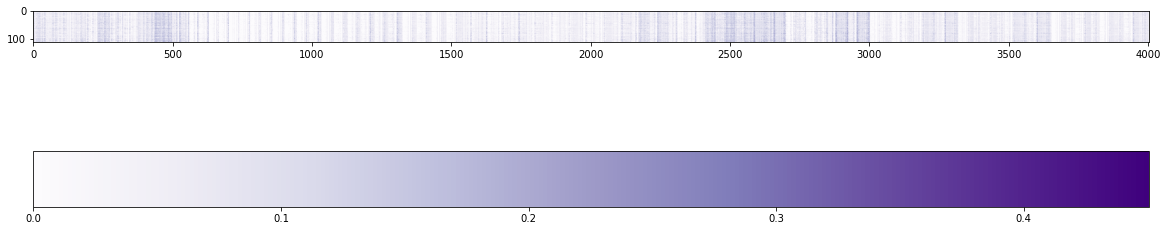

In [9]:
fig,ax=plt.subplots(figsize=(20,10))
im=ax.imshow(inputs_european_connectivity_matrices_schizophrenia,cmap='Purples')
fig.colorbar(im,orientation='horizontal',pad=0.2)
plt.show()

In [10]:
features_to_be_removed=np.asarray([i for i in range(0,4005) if len(np.where(inputs_european_connectivity_matrices_schizophrenia[:,i]==0)[0])/114 > 0])
inputs_european_connectivity_matrices_schizophrenia_removed_zeros=np.delete(inputs_european_connectivity_matrices_schizophrenia,features_to_be_removed,axis=1)
combinations_without_zeros=np.delete(combinations,features_to_be_removed)
inputs_european_connectivity_matrices_schizophrenia_removed_zeros.shape

(114, 737)

# Adjusting for covariates

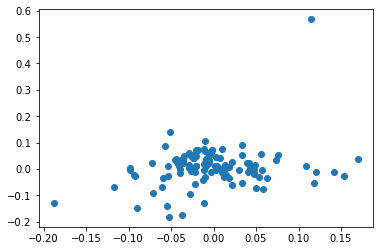

In [11]:
plt.scatter(european_ancestral_PCA[:,2],european_ancestral_PCA[:,3])
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

In [12]:
#adjusting for covariates:
#for PRS: I adjusted for 10 PC. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_PRS_schizophrenia=preprocessing.adjusting_for_covariates_with_lin_reg(y=european_prs_schizophrenia[:,1:],covariates=[european_ancestral_PCA[:,1:4]])#adjust for the first 4 PCs.
adjusted_european_PRS_schizophrenia=adjusted_european_PRS_schizophrenia.astype('float64')

adjusted_european_connectivity_schizophrenia=preprocessing.adjusting_for_covariates_with_lin_reg(y=inputs_european_connectivity_matrices_schizophrenia_removed_zeros,covariates=[european_age_at_scan,european_gestational_age,european_gender])

adjusted_european_structural_schizophrenia=preprocessing.adjusting_for_covariates_with_lin_reg(y=european_volumes,covariates=[european_age_at_scan,european_gestational_age,european_icv,european_gender])
adjusted_european_structural_schizophrenia=adjusted_european_structural_schizophrenia.astype('float64')


# Data Exploration

## Connectivity matrices

After retaining only features that are present in all individuals, I have 737 features left.
* Univariate test to check significance of the features to the target. f-regression (https://stackoverflow.com/questions/52461893/univariate-linear-regression-tests-for-feature-selection)
* Check correlation between the features, and the target.

In [36]:
#UNIVARIATE TESTING. Calculated by first estimating fitting a simple linear model to each regressor, and then calculate the R2. From R2, we calculate the F-score and with that P-value. The False discovery rate method adjust the p-value.

from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection

print('#################connectivity######################')
p_value_dict={}
for p_threshold in range(adjusted_european_PRS_schizophrenia.shape[1]):

    X=adjusted_european_connectivity_schizophrenia
    X=StandardScaler().fit_transform(X)
    y=adjusted_european_PRS_schizophrenia[:,p_threshold]
    y=StandardScaler().fit_transform(y.reshape(-1,1))

    F_score,p_value=f_regression(X,y)
    p_value_dict[p_threshold]=p_value
    survived_idx,adjusted_p_values=fdrcorrection(p_value,alpha=0.05)
    print('For threshold of %s, %d features were significant, but %d survived the FDR correction' %(schizophrenia_high_scores_european.columns[p_threshold+1],
    len(p_value[p_value<0.05]),len(np.where(survived_idx)[0])))

#################connectivity######################
For threshold of 0.100000, 18 features were significant, but 0 survived the FDR correction
For threshold of 0.200000, 9 features were significant, but 0 survived the FDR correction
For threshold of 0.300000, 9 features were significant, but 0 survived the FDR correction
For threshold of 0.400000, 9 features were significant, but 0 survived the FDR correction
For threshold of 0.500000, 10 features were significant, but 0 survived the FDR correction
For threshold of 1.000000, 8 features were significant, but 0 survived the FDR correction


Using the described multiple testing in multilocus analyses using the eigenvalues of a correlation matrix, the new effective number of independent variables using (https://www.nature.com/articles/6800717) equation is **203.7228**. Therefore, the Experiment-wide Significance Threshold Required to Keep I Error Rate at 5% is **0.000251748146207542** . 

*However, none of our features survived this adjusted p-value.*

In [40]:
significant_features=[]
for keys,values in p_value_dict.items():
    significant_features.append(np.where(values<=0.05)[0])

In [41]:
np.unique(np.concatenate(significant_features),return_counts=True)

(array([  6,  12,  52, 132, 166, 182, 196, 220, 406, 408, 418, 431, 471,
        518, 522, 542, 636, 644, 687, 688]),
 array([1, 1, 1, 1, 5, 3, 6, 6, 6, 6, 6, 1, 2, 1, 2, 6, 6, 1, 1, 1]))

In [42]:
combinations_without_zeros[np.unique(np.concatenate(significant_features),return_counts=True)[0]]

array(['MFG.L_ORBsup.L', 'ORBmid.L_MFG.L', 'SMA.L_IFGoperc.L',
       'ACG.L_SFGmed.R', 'PCG.L_INS.L', 'AMYG.L_INS.L', 'CUNE.L_PCG.L',
       'SOG.L_PCG.L', 'CAU.L_MFG.L', 'CAU.L_IFGtriang.L', 'CAU.L_ACG.L',
       'CAU.R_ORBmid.R', 'PUT.L_AMYG.L', 'PAL.L_CAU.L', 'PAL.R_CAU.R',
       'THA.L_CAU.L', 'MTG.L_CUNE.L', 'MTG.L_IPL.L', 'TPOmid.L_TPOsup.L',
       'TPOmid.L_MTG.L'], dtype='<U23')

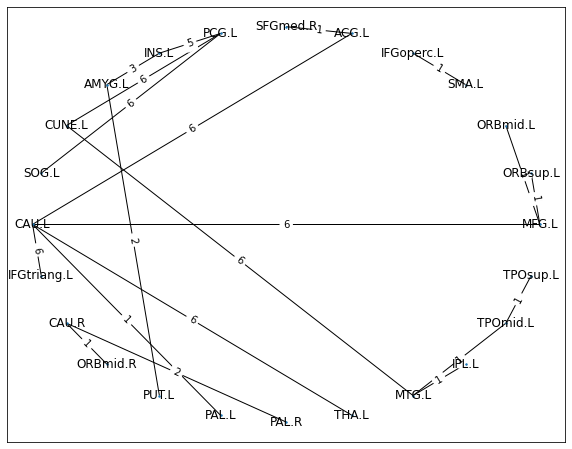

In [43]:
plt.figure(figsize=(10,8))
common_significant_features=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in combinations_without_zeros[np.unique(np.concatenate(significant_features),return_counts=True)[0]]],weight_list=np.unique(np.concatenate(significant_features),return_counts=True)[1])
pos=nx.circular_layout(common_significant_features)
nx.draw_networkx(common_significant_features,pos,node_size=2)
labels=nx.get_edge_attributes(common_significant_features,'weight')
nx.draw_networkx_edge_labels(common_significant_features,pos,edge_labels=labels)
plt.show()

In [123]:
def plot_the_univariate_significant_features(f,axes,p_threshold):

    X=adjusted_european_connectivity_schizophrenia
    X=StandardScaler().fit_transform(X)
    y=adjusted_european_PRS_schizophrenia[:,p_threshold]
    y=StandardScaler().fit_transform(y.reshape(-1,1))

    for idx,ax in enumerate(np.concatenate(axes)):
        ax.plot(X[:,significant_features[p_threshold][idx]],y,'.')
        
        lin_reg=sklearn.linear_model.LinearRegression()
        lin_reg.fit(X[:,significant_features[p_threshold][idx]].reshape(-1,1),y)
        X_pred=np.linspace(np.min(X[:,significant_features[p_threshold][idx]]),np.max(X[:,significant_features[p_threshold][idx]]),50).reshape(-1,1)
        y_pred=lin_reg.predict(X_pred)
        ax.plot(X_pred,y_pred,'r-')

        title_text=','.join([combinations_without_zeros[significant_features[p_threshold][idx]],
    'p:'+str(np.round(p_value_dict[p_threshold][significant_features[p_threshold][idx]],3)),
    'r:'+str(np.round(preprocessing.lower_triangle(np.corrcoef(X[:,significant_features[p_threshold][idx]],y.reshape(-1,1),rowvar=False),2)[0],3))])
        ax.set_title(title_text,fontdict={'fontsize':10})
        if 'CAU' in combinations_without_zeros[significant_features[p_threshold][idx]]:
            ax.set_title(title_text,fontdict={'fontsize':10},color='red')

    f.suptitle('Threshold p-value '+schizophrenia_high_scores_european.columns[p_threshold+1],size='xx-large')
    
    return 


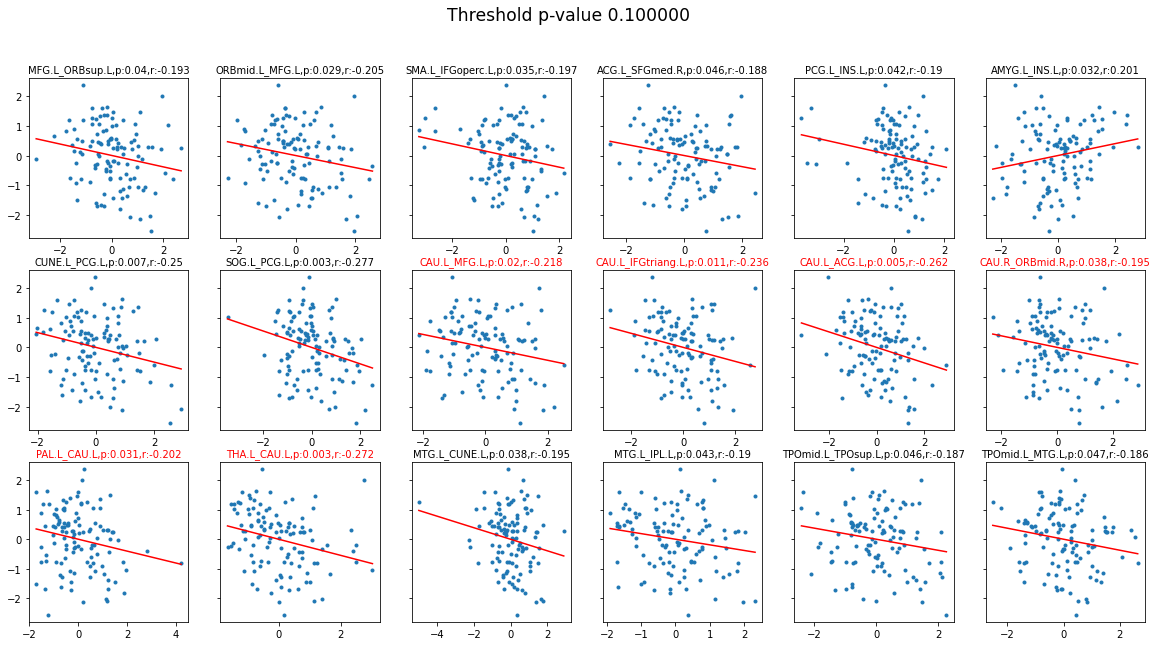

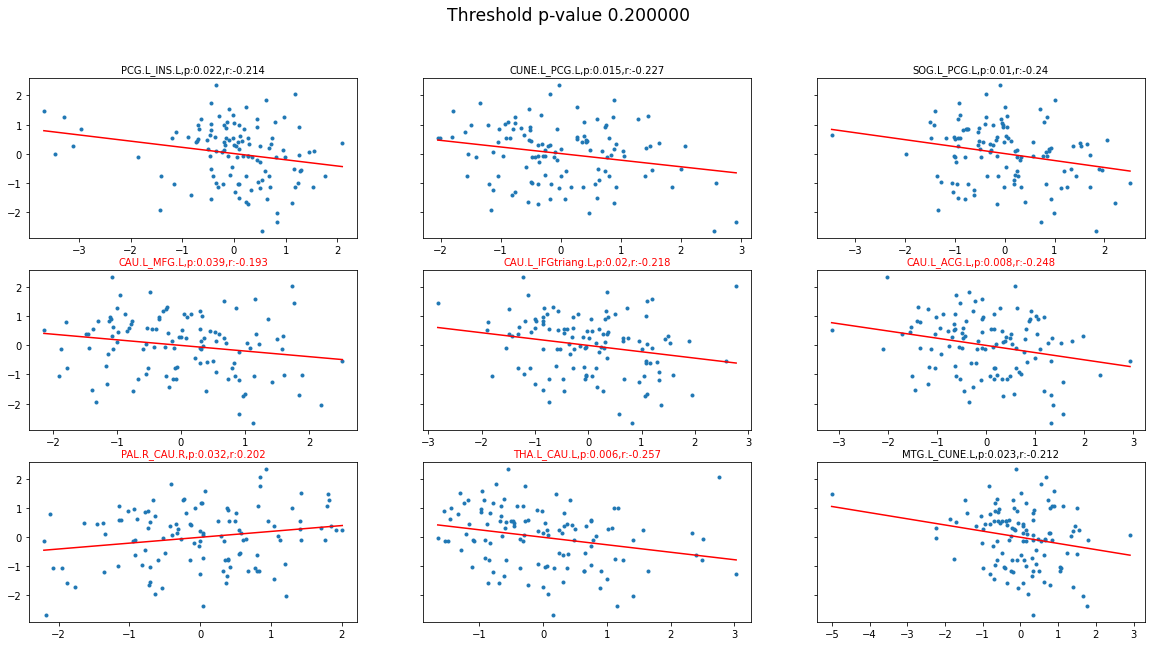

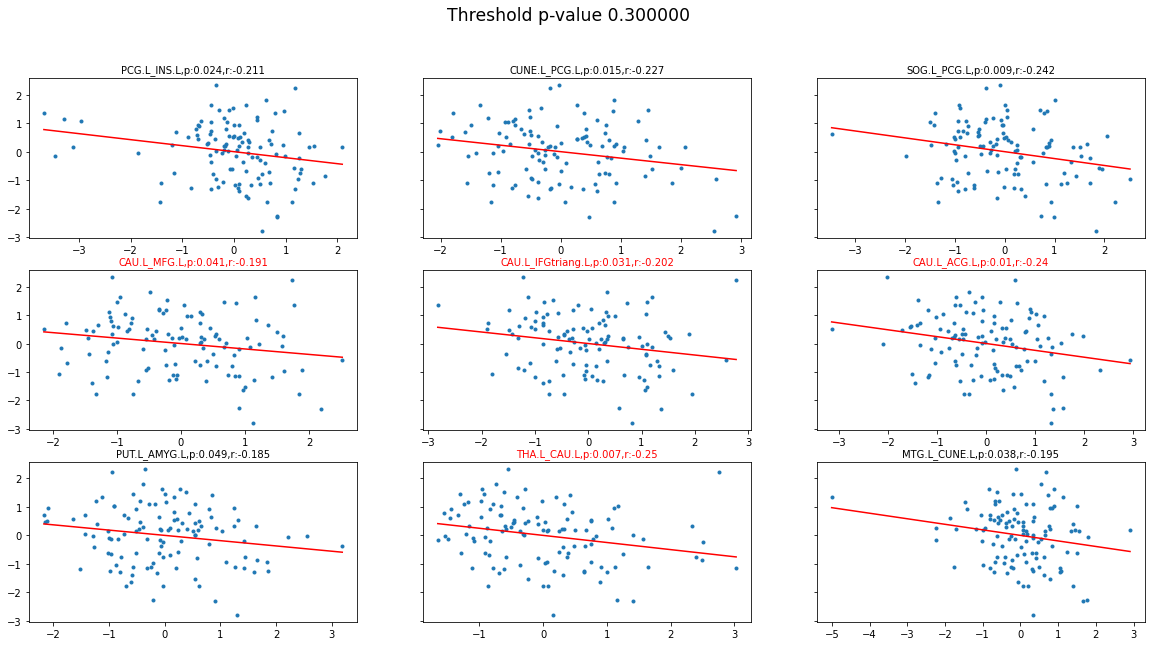

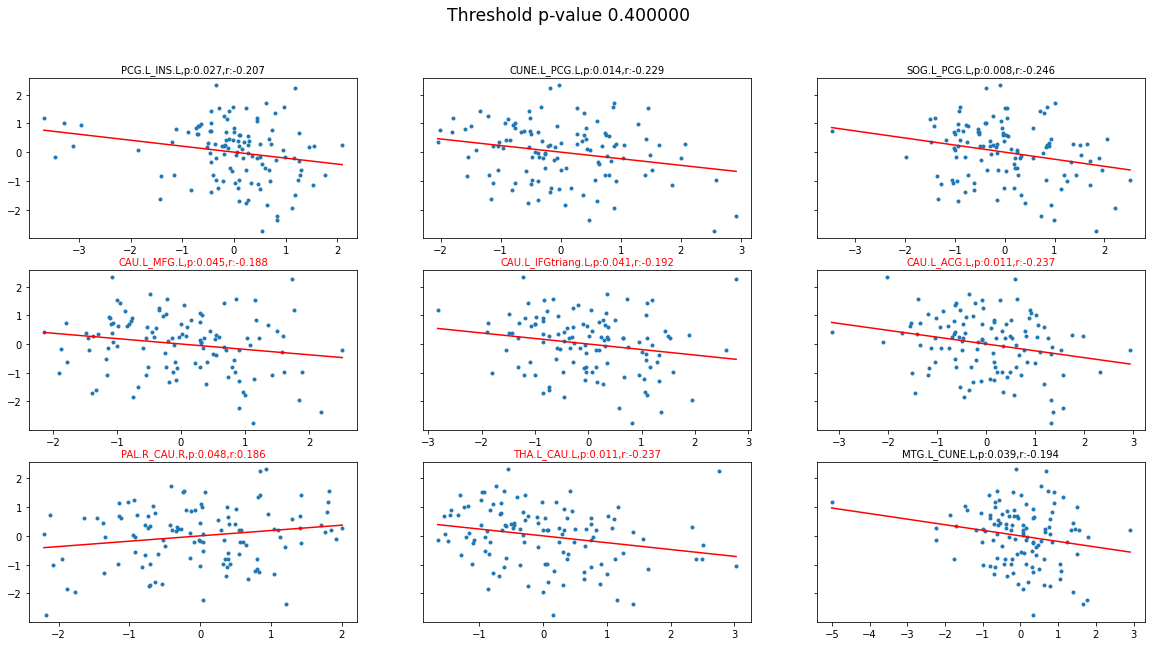

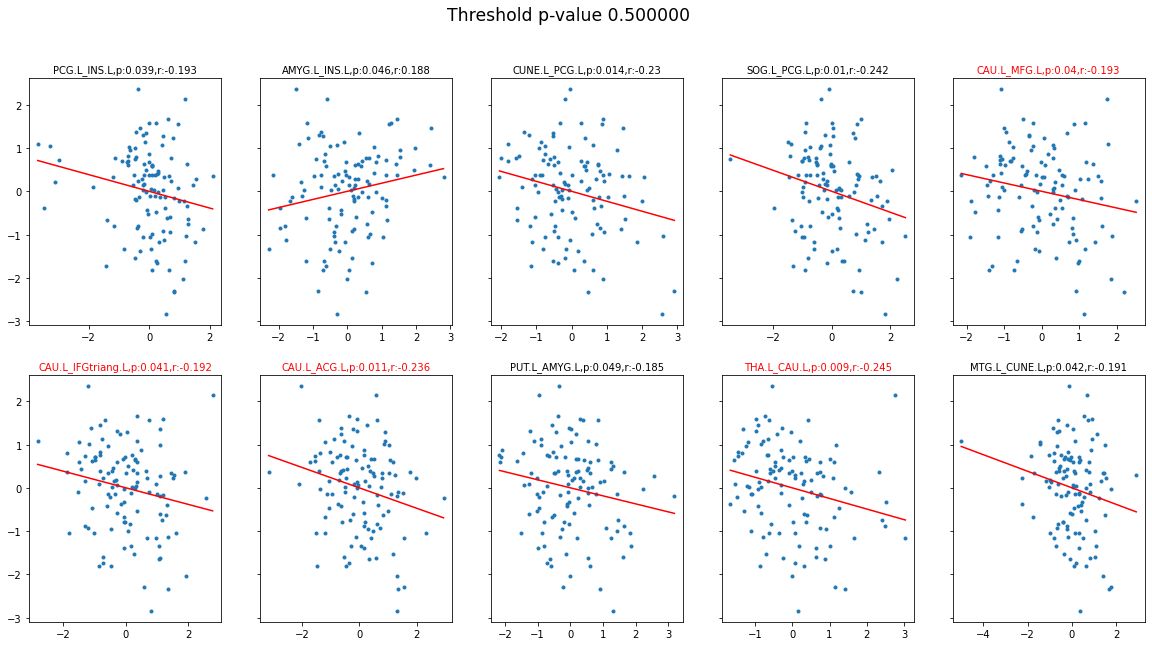

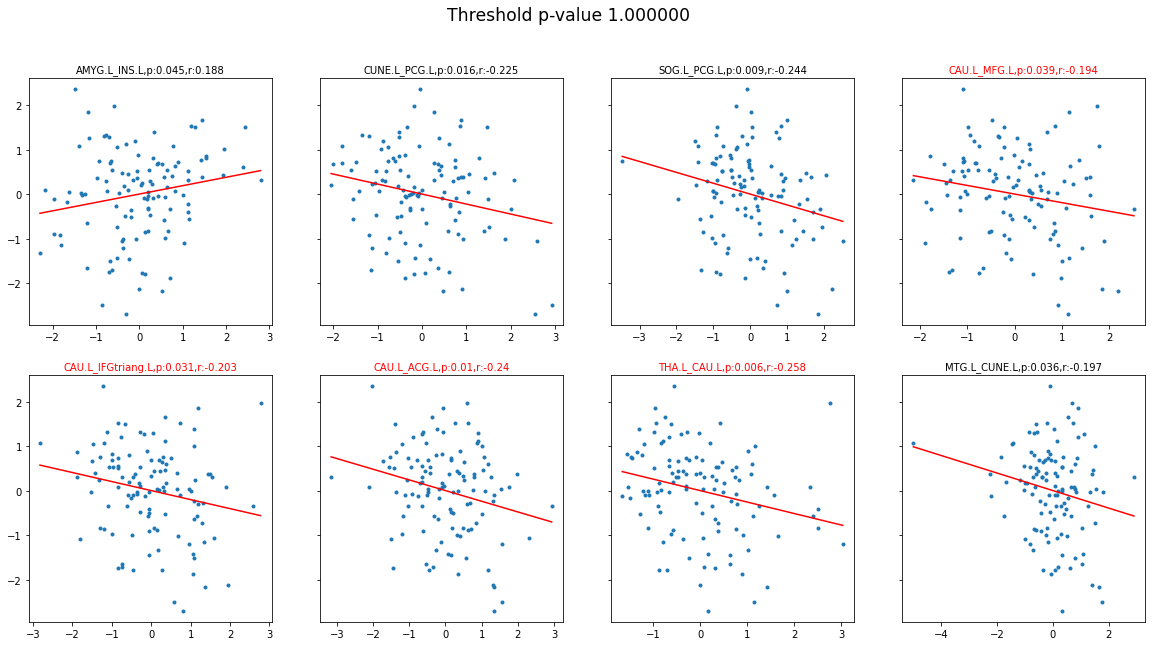

In [126]:
f,axes=plt.subplots(3,6,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,0)

f,axes=plt.subplots(3,3,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,1)

f,axes=plt.subplots(3,3,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,2)

f,axes=plt.subplots(3,3,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,3)

f,axes=plt.subplots(2,5,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,4)

f,axes=plt.subplots(2,4,sharey=True,figsize=(20,10))
plot_the_univariate_significant_features(f,axes,5)

The features appears to be primarily from the left side. 

* With the Caudate both L and R side having a high number of repeated connections across the threshold. Caudate forms the medial part of the striatum and has clear involvement with both cognitive and motor functions. Damage to this structure has been reported to produce a 'schizophrenia-like' state. Caudate is a dense subcortical nucleus, composed of spiny neurons and forms the dorsal striatum along with the putamen.  It recieves projections all the way from the dorsolateral prefrontal cortex and the premotor cortex, and in turn sends projections to the globus pallidus and reciprocal projections to the substantia nigra. There are complex and reciprocal connection between thalamic nuclei and caudate.
    * Caudate - Thalamus: this is part of the 
    * Caudate - Middle Frontal Gyrus, Inferior Frontal Gyrus
    * Caudate - Pallidum
    * Caudate - Anterior Cingulate Gyrus
* Posterior Cingulate Gyrus (PCG) also has 2 connection to Cunneus and 


Dopamine system: 

In [151]:
np.histogram(y,20)

(array([ 1,  2,  2,  4,  4,  7,  3, 10,  6, 11,  6, 15, 14,  7,  6,  9,  5,
         0,  1,  1]),
 array([-2.54605592, -2.3003143 , -2.05457267, -1.80883105, -1.56308943,
        -1.3173478 , -1.07160618, -0.82586456, -0.58012293, -0.33438131,
        -0.08863969,  0.15710194,  0.40284356,  0.64858519,  0.89432681,
         1.14006843,  1.38581006,  1.63155168,  1.8772933 ,  2.12303493,
         2.36877655]))

(array([ 3.,  6., 11., 13., 17., 21., 21., 15.,  5.,  2.]),
 array([-4.36368798e-04, -3.52133431e-04, -2.67898065e-04, -1.83662698e-04,
        -9.94273317e-05, -1.51919652e-05,  6.90434014e-05,  1.53278768e-04,
         2.37514134e-04,  3.21749501e-04,  4.05984868e-04]),
 <a list of 10 Patch objects>)

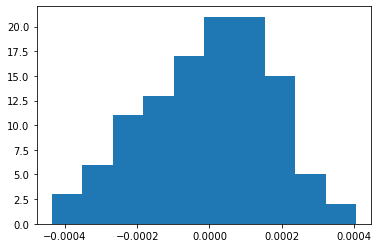

In [158]:
plt.hist(adjusted_european_PRS_schizophrenia[:,0])

(array([ 3.,  6., 11., 13., 17., 21., 21., 15.,  5.,  2.]),
 array([-2.54605592, -2.05457267, -1.56308943, -1.07160618, -0.58012293,
        -0.08863969,  0.40284356,  0.89432681,  1.38581006,  1.8772933 ,
         2.36877655]),
 <a list of 10 Patch objects>)

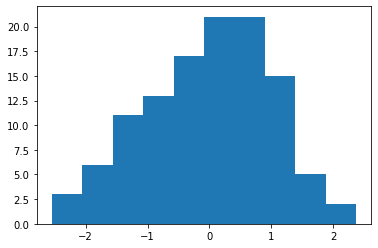

In [156]:
plt.hist(y)

# Training

In [13]:
X=adjusted_european_connectivity_schizophrenia
y=adjusted_european_PRS_schizophrenia[:,4]

In [14]:
# #save the dataset and run external model training script.
# np.save('data_set_X.npy',X)
# np.save('data_set_y.npy',y)
# np.save('data_set_indices.npy',combinations_without_zeros)

In [15]:
# ! python model_training data_set_X.npy data_set_y.npy data_set_indices.npy - run the model_training script in the terminal.

In [17]:
"""
the following are the parameters for tuning in each model:
pipe0__hcr__thresh:np.linspace(0.5,1,6)
pipe0__select_percentile__percentile:np.linspace(20,100,9)
parameters_dict=dict({'lin_reg':None,
                         'lasso':{'alpha':np.linspace(0,100,101),np.linspace(0,1,101)},
                         'ridge':{'alpha':np.linspace(0,100,101)},
                         'random_forest':None,
                         'lin_svr':{'C':np.linspace(0,100,101),'epsilon':np.linspace(0,1,101)},
                         'knn':{'n_neighbors':[int(i) for i in np.linspace(1,10,10)],'weights':['uniform','distance'],'metric':['minkowski','euclidean','manhattan']}})
"""
"""
    [0.5,0.6,0.8] [20,30,50]

"""

## Simple Model:

In [1]:
from model_training import *

In [16]:
lin_reg=load_the_object('./simple_model/lin_reg/objectlin_reg.pkl')
ridge=load_the_object('./simple_model/ridge/objectridge.pkl')
lasso=load_the_object('./simple_model/lasso/objectlasso.pkl')
random_forest=load_the_object('./simple_model/random_forest/objectrandom_forest.pkl')
lin_svr=load_the_object('./simple_model/lin_svr/objectlin_svr.pkl')
knn=load_the_object('./simple_model/knn/objectknn.pkl')
models=[lin_reg,ridge,lasso,lin_svr,knn,random_forest]


In [20]:
df_simple_models=pd.DataFrame({'lvr':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_lvr])][0] for n in models],'rfecv':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_rfecv])][0] for n in models],'sfscv':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_sfscv])][0] for n in models],'test':[[np.mean([np.mean(i) for i in n.test_scores_across_all_splits])][0] for n in models]},[n.model_name for n in models])
df_simple_models

,lvr,rfecv,sfscv,test
lin_reg,-0.501466,-0.301994,NaN,-0.469122
ridge,-0.415256,-0.193335,NaN,-0.171520
lasso,-0.047733,-0.048236,NaN,-0.057402
lin_svr,-0.147198,-0.194087,NaN,-0.183079
knn,-0.038086,NaN,NaN,-0.063428
random_forest,-0.169762,NaN,NaN,-0.116673


## Simple model with p-value selection

In [21]:
lin_reg=load_the_object('./model_p_value/lin_reg/objectlin_reg.pkl')
ridge=load_the_object('./model_p_value/ridge/objectridge.pkl')
lasso=load_the_object('./model_p_value/lasso/objectlasso.pkl')
random_forest=load_the_object('./model_p_value/random_forest/objectrandom_forest.pkl')
lin_svr=load_the_object('./model_p_value/lin_svr/objectlin_svr.pkl')
knn=load_the_object('./model_p_value/knn/objectknn.pkl')
models=[lin_reg,ridge,lasso,lin_svr,knn,random_forest]


In [22]:
df_simple_models=pd.DataFrame({'lvr':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_lvr])][0] for n in models],'rfecv':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_rfecv])][0] for n in models],'sfscv':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_sfscv])][0] for n in models],'test':[[np.mean([np.mean(i) for i in n.test_scores_across_all_splits])][0] for n in models]},[n.model_name for n in models])
df_simple_models

,lvr,rfecv,sfscv,test
lin_reg,-1.075335,-0.759254,-0.756790,-0.792576
ridge,-0.273469,-0.274308,-0.269583,-0.259940
lasso,-0.046195,NaN,NaN,-0.054604
lin_svr,-0.423246,-0.428615,-0.546732,-0.594761
knn,-0.186125,NaN,-0.233115,-0.228201
random_forest,-0.211677,NaN,NaN,-0.148884


## Model with Permutation importance and arrange by F-score

In [28]:
lin_reg=load_the_object('./model1/lin_reg/objectlin_reg.pkl')
ridge=load_the_object('./model1/ridge/objectridge.pkl')
lasso=load_the_object('./model1/lasso/objectlasso.pkl')
random_forest=load_the_object('./model1/random_forest/objectrandom_forest.pkl')
lin_svr=load_the_object('./model1/lin_svr/objectlin_svr.pkl')
knn=load_the_object('./model1/knn_only/objectknn.pkl')
models=[lin_reg,ridge,lasso,lin_svr,knn,random_forest]


In [29]:
df_simple_models=pd.DataFrame({'lvr':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_perm])][0] for n in models],'rfecv':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_rfecv])][0] for n in models],'sfscv':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_sfscv])][0] for n in models],'test':[[np.mean([np.mean(i) for i in n.test_scores_across_all_splits])][0] for n in models]},[n.model_name for n in models])
df_simple_models

,lvr,rfecv,sfscv,test
lin_reg,-0.426745,-0.429762,-0.503206,-1.159083
ridge,-0.335094,-0.334733,-0.337278,-0.528339
lasso,-0.046790,NaN,NaN,-0.059358
lin_svr,-0.166314,-0.166473,-0.494307,-0.292917
knn,-0.153797,NaN,NaN,-0.215663
random_forest,-0.147975,NaN,NaN,-0.214666


## Model with Permutation importance and arrange by Pearson correlation score

In [32]:
lin_reg=load_the_object('./model2/lin_reg/objectlin_reg.pkl')
ridge=load_the_object('./model2/ridge/objectridge.pkl')
lasso=load_the_object('./model2/lasso/objectlasso.pkl')
random_forest=load_the_object('./model2/random_forest/objectrandom_forest.pkl')
lin_svr=load_the_object('./model2/lin_svr/objectlin_svr.pkl')
# knn=load_the_object('./model2/knn_only/objectknn.pkl')
models=[lin_reg,ridge,lasso,lin_svr,random_forest]


In [33]:
df_simple_models=pd.DataFrame({'lvr':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_perm])][0] for n in models],'rfecv':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_rfecv])][0] for n in models],'sfscv':[[np.mean([np.mean(i) for i in n.cross_validated_scores_after_sfscv])][0] for n in models],'test':[[np.mean([np.mean(i) for i in n.test_scores_across_all_splits])][0] for n in models]},[n.model_name for n in models])
df_simple_models

,lvr,rfecv,sfscv,test
lin_reg,-0.997595,-0.782611,-1.401439,-1.531736
ridge,-0.285859,-0.281910,-0.273547,-0.462839
lasso,-0.048347,NaN,NaN,-0.045419
lin_svr,-0.269603,-0.268034,-0.595734,-0.426339
random_forest,-0.134881,NaN,NaN,-0.121646


SOG L - CAL-R (Superior Occipital - Calcarine)
PCG R- CUN L  (posterior cingulate - cuneus) (yes- cuneus- post and anterior cingulum)
CAUR- SOGR (Caudate - Superior Occipital)
CAUR- MOGR (Caudate - Medial Occipital) (caudate to Thalamus, to cingulum anterior, frontal gyrus)
PCL-R PAL-R (Pallidum - Paracentral)
THAL-R TPOmid-R (Thalamus - Temporal pole: middle temporal gyrus) (temporal mid to cuneus, inferior parietal)

